In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np

In [3]:
class KernelType:
    Scatter = 0
    Gather = 1
    Unknown = 2
    @staticmethod
    def stringToKernelType(s):
        if s == "Scatter":
            return KernelType.Scatter
        if s == "Gather":
            return KernelType.Gather
        return KernelType.Unknown
    @staticmethod
    def kernelTypeToString(k):
        if k == KernelType.Scatter:
            return "Scatter"
        if k == KernelType.Gather:
            return "Gather"
        return "Unknown"

class ScatterGatherKernel:
    def __init__(self, index, kernel_type, multiplicity):
        self.index = np.array(index, dtype=np.int64)
        self.kernel_type = kernel_type
        self.multiplicity = multiplicity
    def __str__(self):
        return "\n".join([
            f"Kernel",
            f"  + Type: {KernelType.kernelTypeToString(self.kernel_type)}",
            f"  + Size: {len(self.index)}",
            f"  + Multilicity: {self.multiplicity}"
        ])

def read_spatter_kernel(filename):
    kernels = []
    with open(filename, "r") as f:
        j = json.load(f)
        numKernels = len(j)
        for i in range(numKernels):
            kernels.append(ScatterGatherKernel(
                index = j[i]["pattern"],
                kernel_type = KernelType.stringToKernelType(j[i]["kernel"]),
                multiplicity = j[i]["count"]
            ))
    return kernels

In [9]:
class System:
    def __init__(self, cache_block_size_in_bytes = 2**6, element_size_in_bytes = 2**3, num_lanes = 1):
        self.cache_block_size_in_bytes = cache_block_size_in_bytes
        self.element_size_in_bytes = element_size_in_bytes
        self.num_lanes = 1
    def get_cache_block_index(self, index_list):
        return index_list // (self.cache_block_size_in_bytes // self.element_size_in_bytes)
    def visualize_memory_access_pattern(self, index_list, pattern_name):
        numAddresses = index_list.shape[0]
        plt.scatter(np.arange(numAddresses), index_list // (self.cache_block_size_in_bytes // self.element_size_in_bytes), s=1)
        plt.title(f"Memory access pattern of {pattern_name}")
        plt.xlabel("Time")
        plt.ylabel("Cache Block Accessed")
        y_max = max(index_list) // (self.cache_block_size_in_bytes // self.element_size_in_bytes)
        y_step = 20000
        y_max = y_max + y_step
        plt.yticks(np.arange(0, y_max, step=y_step))
        plt.show()
    def visualize_delta_of_memory_access_pattern(self, index_list, pattern_name):
        delta_list = np.diff(index_list)
        numDeltas = delta_list.shape[0]
        outlier = np.abs(delta_list) < 10**5
        delta_list *= outlier
        plt.scatter(np.arange(numDeltas), delta_list, s=1)
        plt.title(f"Memory access pattern of {pattern_name}")
        plt.xlabel("Time")
        plt.ylabel("Deltas")
        plt.show()
system = System()

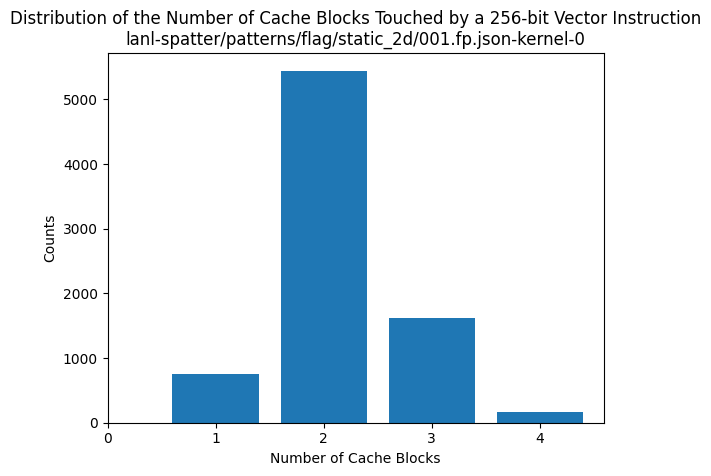

In [50]:
spatter_file = "lanl-spatter/patterns/flag/static_2d/001.fp.json"
kernels = read_spatter_kernel(spatter_file)
kernel = kernels[0]
index = kernel.index
cache_block_index = system.get_cache_block_index(index)

vector_length = 256 # in bits
vector_length_in_bytes = vector_length // 8
element_size_in_bytes = 2**3
num_elements_per_vector = vector_length_in_bytes // element_size_in_bytes
num_index = len(cache_block_index)
freq = {}
for offset in range(0, num_index, num_elements_per_vector):
    count = len(np.unique(cache_block_index[offset:offset+num_elements_per_vector]))
    if not count in freq:
        freq[count] = 0
    freq[count] = freq[count] + 1
plt.bar(list(freq.keys()), list(freq.values()))
plt.xticks(np.arange(0, max(freq.keys())+1))
plt.title(f"Distribution of the Number of Cache Blocks Touched by a {vector_length}-bit Vector Instruction\n{spatter_file}-kernel-0")
plt.xlabel("Number of Cache Blocks")
plt.ylabel("Counts");

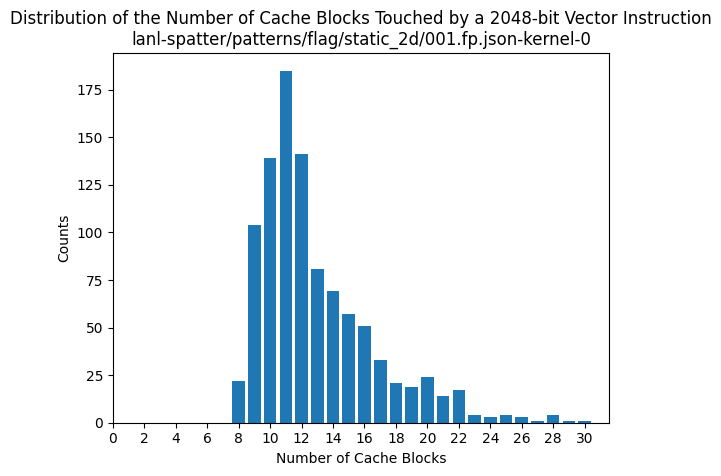

In [58]:
spatter_file = "lanl-spatter/patterns/flag/static_2d/001.fp.json"
kernels = read_spatter_kernel(spatter_file)
kernel = kernels[0]
index = kernel.index
cache_block_index = system.get_cache_block_index(index)

vector_length = 2048 # in bits
vector_length_in_bytes = vector_length // 8
element_size_in_bytes = 2**3
num_elements_per_vector = vector_length_in_bytes // element_size_in_bytes
num_index = len(cache_block_index)
freq = {}
for offset in range(0, num_index, num_elements_per_vector):
    count = len(np.unique(cache_block_index[offset:offset+num_elements_per_vector]))
    if not count in freq:
        freq[count] = 0
    freq[count] = freq[count] + 1
plt.bar(list(freq.keys()), list(freq.values()))
plt.xticks(list(range(0, max(freq.keys())+1, 2)))
plt.title(f"Distribution of the Number of Cache Blocks Touched by a {vector_length}-bit Vector Instruction\n{spatter_file}-kernel-0")
plt.xlabel("Number of Cache Blocks")
plt.ylabel("Counts");

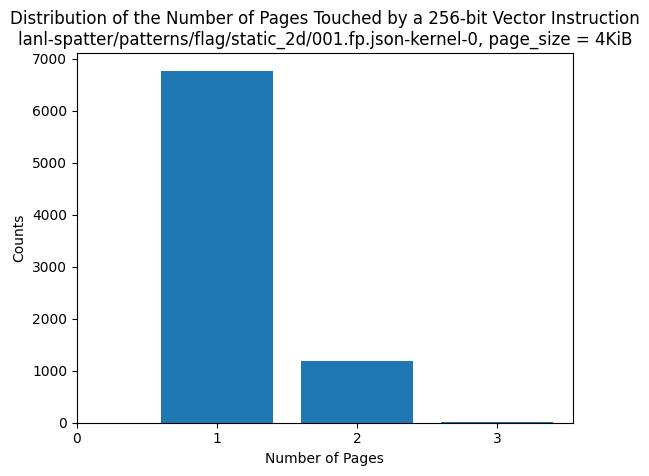

In [52]:
vector_length = 256 # in bits
vector_length_in_bytes = vector_length // 8
element_size_in_bytes = 2**3
page_size_in_bytes = 1 << 12 # 4KiB

page_index = element_size_in_bytes * index // page_size_in_bytes
num_elements_per_vector = vector_length_in_bytes // element_size_in_bytes
num_index = len(cache_block_index)
freq = {}
for offset in range(0, num_index, num_elements_per_vector):
    count = len(np.unique(page_index[offset:offset+num_elements_per_vector]))
    if not count in freq:
        freq[count] = 0
    freq[count] = freq[count] + 1
plt.bar(list(freq.keys()), list(freq.values()))
plt.xticks(list(range(0, max(freq.keys())+1)))
plt.title(f"Distribution of the Number of Pages Touched by a {vector_length}-bit Vector Instruction\n{spatter_file}-kernel-0, page_size = 4KiB")
plt.xlabel("Number of Pages")
plt.ylabel("Counts");

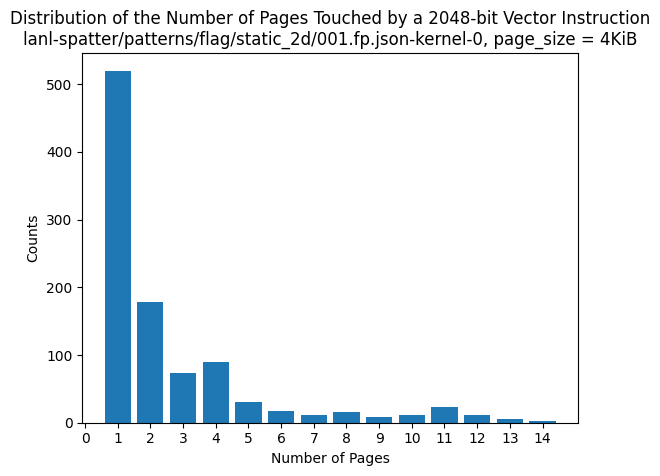

In [55]:
vector_length = 2048 # in bits
vector_length_in_bytes = vector_length // 8
element_size_in_bytes = 2**3
page_size_in_bytes = 1 << 12 # 4KiB

page_index = element_size_in_bytes * index // page_size_in_bytes
num_elements_per_vector = vector_length_in_bytes // element_size_in_bytes
num_index = len(cache_block_index)
freq = {}
for offset in range(0, num_index, num_elements_per_vector):
    count = len(np.unique(page_index[offset:offset+num_elements_per_vector]))
    if not count in freq:
        freq[count] = 0
    freq[count] = freq[count] + 1
plt.bar(list(freq.keys()), list(freq.values()))
plt.xticks(list(range(0, max(freq.keys())+1)))
plt.title(f"Distribution of the Number of Pages Touched by a {vector_length}-bit Vector Instruction\n{spatter_file}-kernel-0, page_size = 4KiB")
plt.xlabel("Number of Pages")
plt.ylabel("Counts");

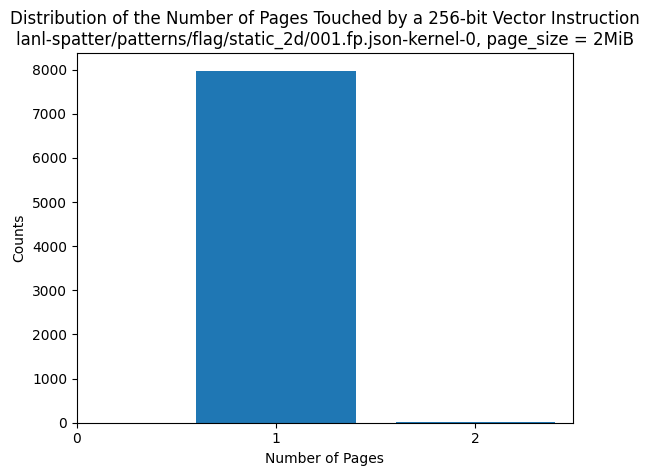

In [60]:
vector_length = 256 # in bits
vector_length_in_bytes = vector_length // 8
element_size_in_bytes = 2**3
page_size_in_bytes = 1 << 21 # 4KiB

page_index = element_size_in_bytes * index // page_size_in_bytes
num_elements_per_vector = vector_length_in_bytes // element_size_in_bytes
num_index = len(cache_block_index)
freq = {}
for offset in range(0, num_index, num_elements_per_vector):
    count = len(np.unique(page_index[offset:offset+num_elements_per_vector]))
    if not count in freq:
        freq[count] = 0
    freq[count] = freq[count] + 1
plt.bar(list(freq.keys()), list(freq.values()))
plt.xticks(list(range(0, max(freq.keys())+1)))
plt.title(f"Distribution of the Number of Pages Touched by a {vector_length}-bit Vector Instruction\n{spatter_file}-kernel-0, page_size = 2MiB")
plt.xlabel("Number of Pages")
plt.ylabel("Counts");

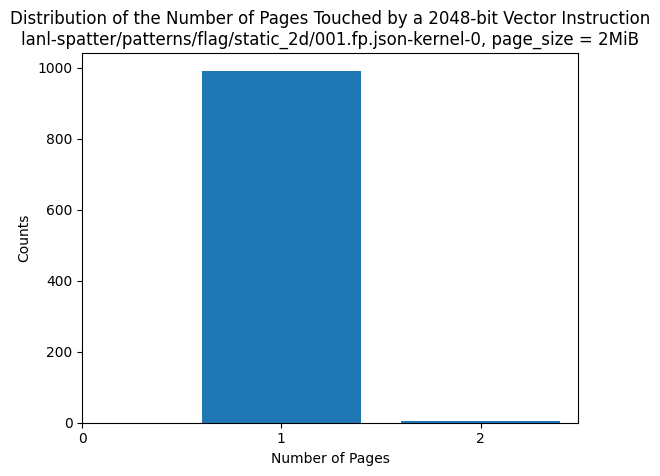

In [61]:
vector_length = 2048 # in bits
vector_length_in_bytes = vector_length // 8
element_size_in_bytes = 2**3
page_size_in_bytes = 1 << 21 # 4KiB

page_index = element_size_in_bytes * index // page_size_in_bytes
num_elements_per_vector = vector_length_in_bytes // element_size_in_bytes
num_index = len(cache_block_index)
freq = {}
for offset in range(0, num_index, num_elements_per_vector):
    count = len(np.unique(page_index[offset:offset+num_elements_per_vector]))
    if not count in freq:
        freq[count] = 0
    freq[count] = freq[count] + 1
plt.bar(list(freq.keys()), list(freq.values()))
plt.xticks(list(range(0, max(freq.keys())+1)))
plt.title(f"Distribution of the Number of Pages Touched by a {vector_length}-bit Vector Instruction\n{spatter_file}-kernel-0, page_size = 2MiB")
plt.xlabel("Number of Pages")
plt.ylabel("Counts");